# Using TracInCP to identify model-based comparable by examining proponents

The goal of this notebook is to replicate the experiment on the California Housing Prices dataset, consisting in measuring the proponents for 11 instances in the test set.
The 11 proponents are examples that scored a positive value of influence as proponents, since they are particularly helpful in the reduction of loss.
These 11 instances are houses located in Palo Alto, which is a well know city in the Bay area for its expensive housing.

1) Import of necessary libraries and cuda:


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
from tqdm import tqdm
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2) The model is created identical to the one used to generate the checkpoints, which resembled the Network used in the paper.

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(8, 400)
        self.fc2 = nn.Linear(400, 400)
        self.fc3 = nn.Linear(400, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

3) Dataset is fetched and splitted into Train and Test set with a 8:2 ratio

In [17]:
# Load the California housing dataset
data = fetch_california_housing()

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    data.data, data.target, test_size=0.2, random_state=42
)

4) To replicate the test proposed by the paper, the instances located at Palo Alto, CA are selected by setting latitude and longitude ranges in order to extract the correct samples.

In [18]:
# Define the longitude and latitude ranges
longitude_range = (-122.168065, -122.124046)
latitude_range = (37.429623, 37.453237)

# Apply the selection based on the ranges
selected_indices = []
for i, instance in enumerate(X_test):
    longitude = instance[-1].item()
    latitude = instance[-2].item()
    if longitude_range[0] <= longitude <= longitude_range[1] and \
            latitude_range[0] <= latitude <= latitude_range[1]:
        selected_indices.append(i)

# Select instances from X_test and Y_test based on the selected indices
selected_instances_X = X_test[selected_indices][:11]
selected_instances_Y = Y_test[selected_indices][:11]

4.1) The following cell just plots a map of the points in the dataset and shows the location of the selected instances. This is useful to check whether they're correctly selected from Palo Alto as expected.

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

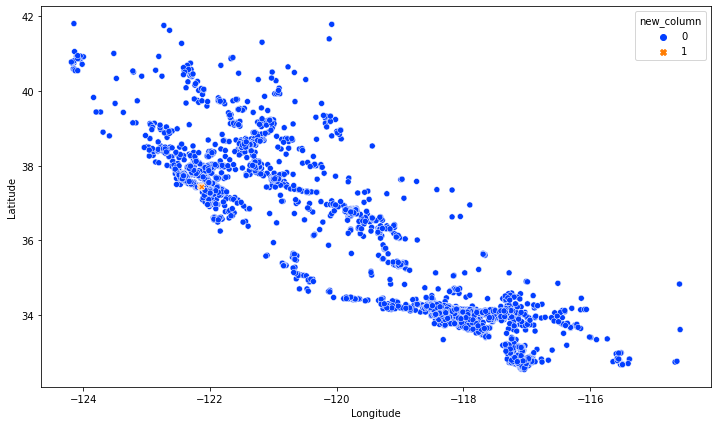

In [19]:
california_frame = fetch_california_housing(as_frame=True)

train_data_frame, test_data_frame = train_test_split(california_frame.data, test_size=0.2, random_state=42)
# Create a new column 'new_column' and initialize it with zeros
test_data_frame.reset_index(inplace=True, drop=True)
test_data_frame['new_column'] = 0
# Set the value to 1 for rows at 'max_val_indices'
test_data_frame.loc[selected_indices[0:11], 'new_column'] = 1
test_data_frame = test_data_frame.sort_values('new_column', ascending=True)
plt.figure(figsize=(12,7))
sns.scatterplot(data = test_data_frame, x='Longitude', y='Latitude', hue='new_column', palette="bright", style='new_column')

5) As usual, datasets are scaled and converted into tensors

In [20]:
# Standardize the features
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
selected_instances_X = scaler.fit_transform(selected_instances_X)

In [21]:
# Convert data to Torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
selected_instances_X = torch.tensor(selected_instances_X, dtype=torch.float32)

# Convert labels to Torch tensors
Y_train = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1)
selected_instances_Y = torch.tensor(selected_instances_Y, dtype=torch.float32).view(-1, 1)

6) this is the main function implementing TracInCP and calculating the scores for the each of the 11 instances selected of the entire train set.
Running this function on all the 20 checkpoints requires almost 20 minutes therefor we decided to run it just on 3 selected checkpoints. The results on both the cases are very close to each other. 

In [22]:
def run_proponent_opponent(models, criterion):
  scores = np.zeros(len(X_train))

  for n in tqdm(range(len(models))):
    model = models[n]
    model.to(device)
    for i in range(len(selected_instances_X)):
      pred_test = model(selected_instances_X[i].to(device))
      loss_test = criterion(pred_test, selected_instances_Y[i].to(device))
      grads_test = torch.autograd.grad(loss_test, list(model.parameters()))
      for j in range(len(X_train)):
        pred_train = model(X_train[j].to(device))
        loss_train = criterion(pred_train, Y_train[j].to(device))
        grad_train = torch.autograd.grad(loss_train, list(model.parameters()))
        for z in range(len(grad_train)):
          scores[j] += torch.sum(grad_train[z] * grads_test[z])
  return scores

In [23]:
def load_checkpoints(path, checkpoints):
  models = []
  for i in checkpoints:
    model = Net()
    model.load_state_dict(torch.load(path+str(i)+"chpcheckpoint.pth.tar"))
    models.append(model)
  return models

7) These 2 cells show the plot of the proponent results on the data using the Batch size 64 checkpoints

In [24]:
# batch_64
models = []
ph = "./CHP_checkpoints/batch_64/"
criterion = nn.MSELoss()
#range(0, 200, 10):
models = load_checkpoints(ph, [50, 100, 190])

scores = run_proponent_opponent(models, criterion)

100%|████████████████████████████████████████████| 3/3 [07:21<00:00, 147.25s/it]


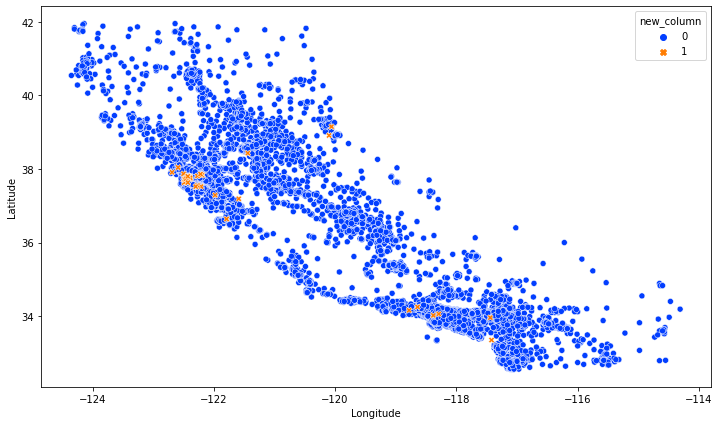

In [26]:
california_frame = fetch_california_housing(as_frame=True)

train_data_frame, test_data_frame = train_test_split(california_frame.data, test_size=0.2, random_state=42)

self_influences_copy = scores.copy()

sorted_indices = []
sorted_indices = sorted(range(len(self_influences_copy)), key=lambda i: self_influences_copy[i], reverse=True)
sorted_indices[0:5]

# Create a new column 'new_column' and initialize it with zeros
train_data_frame.reset_index(inplace=True, drop=True)
train_data_frame['new_column'] = 0
# Set the value to 1 for rows at 'max_val_indices'
train_data_frame.loc[sorted_indices[0:50], 'new_column'] = 1

train_data_frame1 = train_data_frame.sort_values('new_column', ascending=True)

plt.figure(figsize=(12,7))
sns.scatterplot(data = train_data_frame1, x='Longitude', y='Latitude', hue='new_column', 
                palette="bright", style='new_column')
plt.savefig('plot64.png')

8) These 2 cells show the plot of the proponent results on the data using the Batch size 32 checkpoints

In [ ]:
# batch_32
models = []
ph = "./CHP_checkpoints/batch_32/"
criterion = nn.MSELoss()
#range(0, 200, 10):
models = load_checkpoints(ph, [50, 100, 190])

scores = run_proponent_opponent(models, criterion)

100%|██████████| 3/3 [07:04<00:00, 141.64s/it]


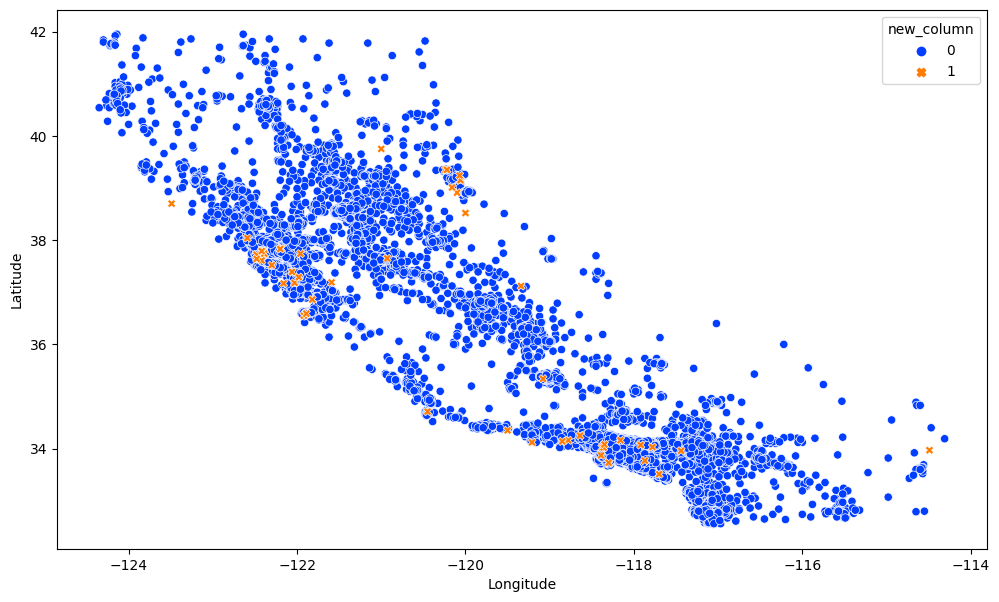

In [ ]:
california_frame = fetch_california_housing(as_frame=True)

train_data_frame, test_data_frame = train_test_split(california_frame.data, test_size=0.2, random_state=42)

self_influences_copy = scores.copy()

sorted_indices = []
sorted_indices = sorted(range(len(self_influences_copy)), key=lambda i: self_influences_copy[i], reverse=True)
sorted_indices[0:5]

# Create a new column 'new_column' and initialize it with zeros
train_data_frame.reset_index(inplace=True, drop=True)
train_data_frame['new_column'] = 0
# Set the value to 1 for rows at 'max_val_indices'
train_data_frame.loc[sorted_indices[0:50], 'new_column'] = 1

train_data_frame2 = train_data_frame.sort_values('new_column', ascending=True)

plt.figure(figsize=(12,7))
sns.scatterplot(data = train_data_frame2, x='Longitude', y='Latitude', hue='new_column', palette="bright", style='new_column')
plt.savefig('plot32.png')

9) These 2 cells show the plot of the proponent results on the data using the Batch size 8 checkpoints

In [ ]:
# batch_8
models = []
ph = "./CHP_checkpoints/batch_8/"
criterion = nn.MSELoss()
#range(0, 200, 10):
models = load_checkpoints(ph, [50, 100, 190])

scores = run_proponent_opponent(models, criterion)

100%|██████████| 3/3 [07:06<00:00, 142.25s/it]


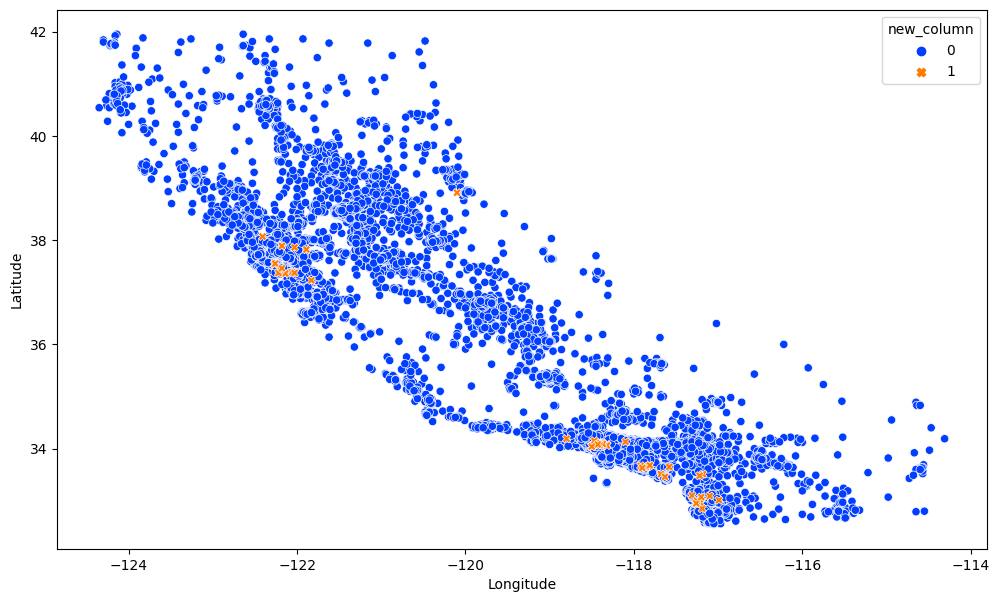

In [ ]:
california_frame = fetch_california_housing(as_frame=True)

train_data_frame, test_data_frame = train_test_split(california_frame.data, test_size=0.2, random_state=42)

self_influences_copy = scores.copy()

sorted_indices = []
sorted_indices = sorted(range(len(self_influences_copy)), key=lambda i: self_influences_copy[i], reverse=True)
sorted_indices[0:5]

# Create a new column 'new_column' and initialize it with zeros
train_data_frame.reset_index(inplace=True, drop=True)
train_data_frame['new_column'] = 0
# Set the value to 1 for rows at 'max_val_indices'
train_data_frame.loc[sorted_indices[0:50], 'new_column'] = 1

train_data_frame3 = train_data_frame.sort_values('new_column', ascending=True)

plt.figure(figsize=(12,7))
sns.scatterplot(data = train_data_frame3, x='Longitude', y='Latitude', hue='new_column', palette="bright", style='new_column')
plt.savefig('plot8.png')

10) Here is a representation side by side of the results from the different batch sizes, and as can be seen the first image on the left is the more similar to the outcome of the paper's experiment.

In conclusion, as for the self influence experiment, we tried various set configurations for training with different batch sizes.
Regarding the experiment that was attempted to emulate, we found that proponents are situated in desely populated areas like Los Angeles, Sacramento, the Bay Area and San Francisco also know for expensive housing.

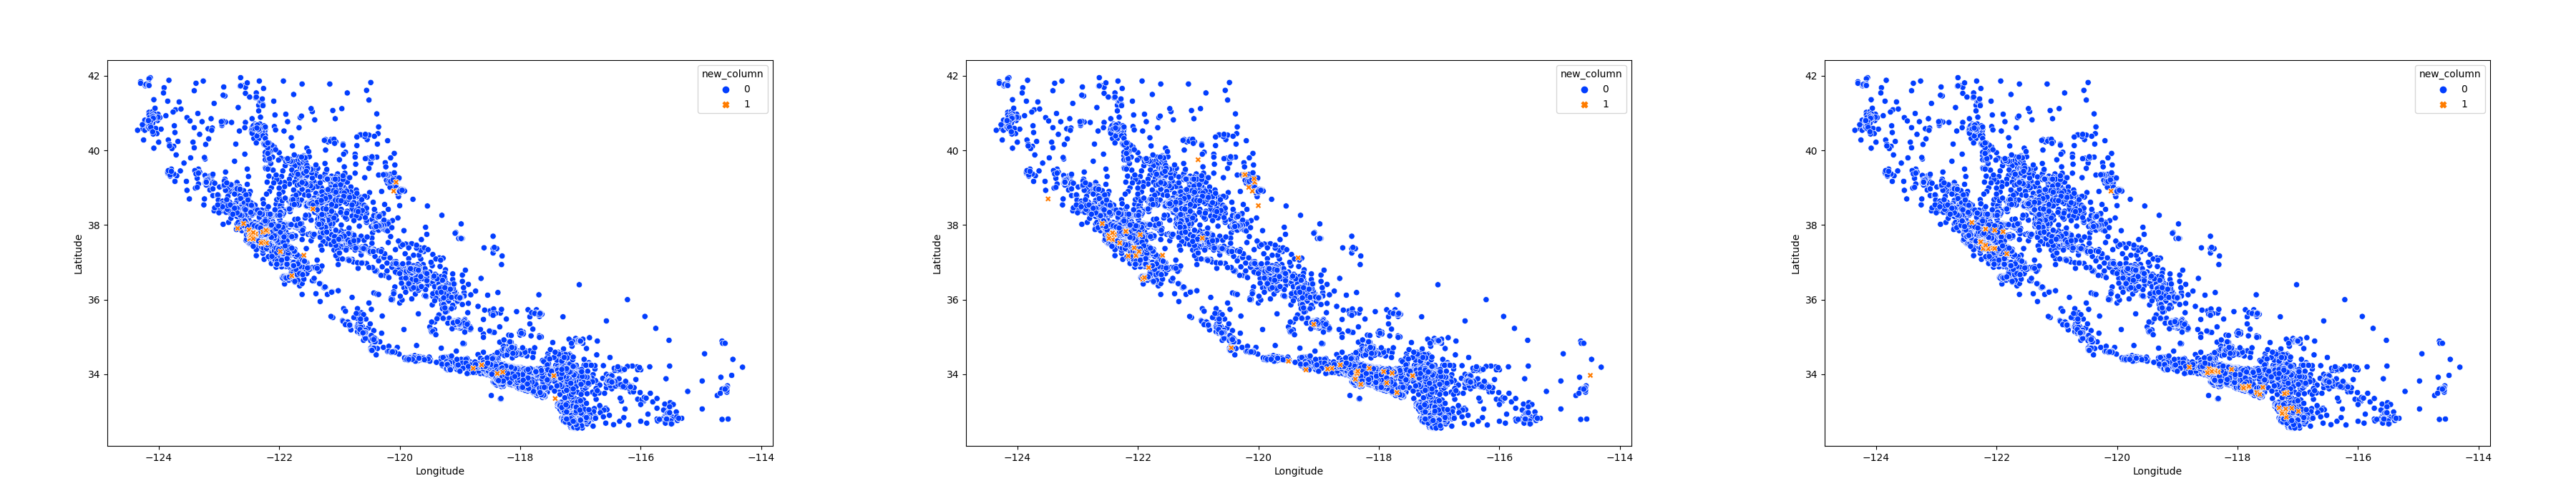

In [ ]:
# Load the three images
image1 = Image.open('plot64.png')
image2 = Image.open('plot32.png')
image3 = Image.open('plot8.png')

# Adjust the size of the images (if needed)
# image1 = image1.resize((width, height))
# image2 = image2.resize((width, height))
# image3 = image3.resize((width, height))

# Convert the images to NumPy arrays
array1 = np.array(image1)
array2 = np.array(image2)
array3 = np.array(image3)

# Horizontally concatenate the image arrays
concatenated_array = np.concatenate((array1, array2, array3), axis=1)

# Convert the concatenated array back to an image
concatenated_image = Image.fromarray(concatenated_array)

# Display the concatenated image
concatenated_image.show()